In [13]:
# number of characteristics
# read all countries from the data/countries.json file 
import json
import ast
countries = json.load(open("data/countries.json"))
countries = list(countries.keys())

with open("data/languages.txt") as f:
    languages = ast.literal_eval(f.readlines()[0])

with open("data/dishes.txt") as f:
    dishes = f.readlines()[0].split(",")

with open("data/genres.txt") as f:
    genres = f.readlines()[0].split(",")

with open("data/religions.txt") as f:
    religions = f.readlines()[0].split(",")

# strip spaces and newlines
list_stripper = lambda x: [c.strip() for c in x]
countries = list_stripper(countries)
languages = list_stripper(languages)
dishes = list_stripper(dishes)[:-1]
genres = list_stripper(genres)[:-1]
religions = list_stripper(religions)[:-1]

# number of characteristics table
n_char = [len(countries), len(languages), len(dishes), len(genres), len(religions)]
n_char

[245, 185, 184, 17, 19]

In [14]:
# from matplotlib.pyplot import subplots
# from itertools import chain, islice
# from string import ascii_uppercase
# from numpy.random import choice
# from venn import venn
# %matplotlib inline

# letters = iter(ascii_uppercase)

# from venn import venn

# dataset_dict = {
#     'Countries': set(countries),
#     'Languages': set(languages),
#     'Food': set(dishes),
#     'Music': set(genres),
#     'Religion': set(religions),
# }




In [16]:
country_template = "They are from {Countries}."
language_template = "They speak {Languages}."
food_template = "They eat {Food}."
music_template = "They listen to {Music}."
religion_template = "They follow the religion {Religion}."

In [17]:
# chose 24 random countries from the list
from numpy.random import choice
np.random.seed(0)
new_countries = choice(countries, 24, replace=False)
new_languages = choice(languages, 18, replace=False)
new_dishes = choice(dishes, 18, replace=False)
new_genres = choice(genres, 4, replace=False)
new_religions = choice(religions, 4, replace=False)

sample_data = {
    'Countries': [new_countries, country_template],
    'Languages': [new_languages, language_template],
    'Food': [new_dishes, food_template],
    'Music': [new_genres, music_template],
    'Religion': [new_religions, religion_template],
}

In [18]:
# perform a stratified sampling of the adjectives
# to get a representative sample of adjectives
# for each characteristic
# weigh the attributes by their sentiment score using nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# get the sentiment score of each attribute
def get_sentiment_score(attribute):
    score = sid.polarity_scores(attribute)
    return score['compound']

with open("data/english-adjectives.txt") as f:
    attributes = f.readlines()
attributes = [a.strip() for a in attributes]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gaurishkatlana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


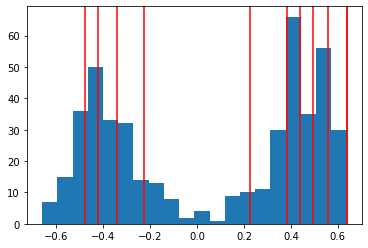

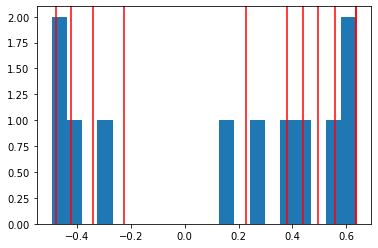

In [19]:
# get the sentiment score of each attribute
sentiment_scores = [(a,get_sentiment_score(a)) for a in attributes if get_sentiment_score(a) != 0]

# plot the sentiment scores
import matplotlib.pyplot as plt
%matplotlib inline

# get the positive and negative attributes

n = len(sentiment_scores)
bin_number = 10 
bin_size = n // bin_number

# sort the attributes by their sentiment score
sentiment_scores.sort(key=lambda x: x[1])
# get all the bins
bins = [sentiment_scores[i: i + bin_size ] for i in range(0, n-1, bin_size)]

# plot the bins on the histogram
plt.hist([s[1] for s in sentiment_scores], bins=20)
for i, b in enumerate(bins):
    plt.axvline(x=b[-1][1], color='r')
plt.show()

# sample 1 attribute from each bin
# to get a representative sample of adjectives

sample_adjectives = []
np.random.seed(0)
for b in bins:
    sample_adjectives.append(np.random.choice([i[0] for i in b],1)[0])

# plot the sentiment scores of the sampled adjectives
plt.hist([get_sentiment_score(a) for a in sample_adjectives], bins=20)
for i, b in enumerate(bins):
    plt.axvline(x=b[-1][1], color='r')

plt.show()




In [48]:
from tqdm import tqdm

from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, BertForMaskedLM

tok = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")


def probs_with_multiple_mask(words,template):
    """
    Find the probability of each MASK Token being a word in the list words
    in order. 

    :words: list of words that we need to find the probability 
    :template: the template that we need to fill in the words (with mask tokens)

    :return: list of probabilities for each word in the list words
    """
    input_idx = tok.encode(template)
    logits = bert(torch.tensor([input_idx]))[0]
    l = F.softmax(logits, dim=1)

    # find all mask tokens
    mask_tokens = [i for i, x in enumerate(input_idx) if x == 103]
    probs = []
    indices = [tok.convert_tokens_to_ids(word) for word in words]
    for mask_token, idx in zip(mask_tokens, indices):
        cur_l = l[0, mask_token, :]
        prob = cur_l[idx].item()
        probs.append(prob)
    return probs

def multiple_characteristics(char_data, template, adjectives):
    """
    char_data: a dictionary with the characteristics and their values, templates
    template: a string with the template for the interaction
    adjectives: a list of adjectives to be used in the interaction
    returns: 
    """
    # make all the combination of the characteristics data 
    from collections import OrderedDict
    char_data = OrderedDict(char_data)
    from itertools import product
    char_combinations = list(product(*char_data.values()))
    key_order = list(char_data.keys())
    # itertools maintains the order of the elements
    print(f"Number of combinations: {len(char_combinations)}")
    print(key_order)

    rows = []
    for char_combination in tqdm(char_combinations):
        template_base = template.replace("{Adjective}", "[MASK]") 
        probs_base = probs_with_multiple_mask(char_combination, template_base)
        probs_base = np.sum(np.log(probs_base))
        for adjective in adjectives:
            for i, key in enumerate(key_order):
                template = template.replace("{" + key + "}", "[MASK]")
                # print(template)
            template2 = template.replace("{Adjective}", adjective) 
            probs = probs_with_multiple_mask(char_combination, template2)
            probs = np.sum(np.log(probs))
            row =   [adjective] + [key_order] + [list(char_combination)] + [probs] + [probs_base]
            rows.append(row)
    return rows

def interaction_bias(n: int, sample_data: dict, sample_adjectives: list):
    """
    n: number of characteristics in the interaction
    sample_data: a dictionary with the characteristics and their values, templates
    sample_adjectives: a list of adjectives to be used in the interaction

    returns: 
    """
    # generate all possible combinations of the characteristics
    from itertools import combinations
    char_combinations = list(combinations(sample_data.keys(), n))
    print(f"Number of combinations: {len(char_combinations)}")
    CG_score = {}
    modified_cg_score = {}
    df = pd.DataFrame(columns=['Adjective', 'Characteristics', 'Values', 'Probs', 'Probs_base'])
    for i, c in enumerate(tqdm(char_combinations)):
        template = " ".join([sample_data[k][1] for k in c])
        template = template + " They are a {Adjective}."
        print(f"Interaction {i+1}: {template}")
        # make the sample data
        char_data = {k: sample_data[k][0] for k in c}
        rows = multiple_characteristics(char_data, template, sample_adjectives)
        # for every adjective calculate variance in probabilities
        variance = np.array([row[3]/row[4] for row in rows]) 
        CG_score[c] = variance.var(axis=0)
        # get all adjective sentiment scores
        sentiment_scores = np.absolute([get_sentiment_score(row[0]) for row in rows])
        modified_cg_score[c] = np.var(variance * sentiment_scores)
        df = df.append(pd.DataFrame(rows, columns=['Adjective', 'Characteristics', 'Values', 'Probs', 'Probs_base']))

    
    # convert to json files
    import json
    with open(f"CG_score_{n}.json", "w") as f:
        json.dump(CG_score, f)
    with open(f"modified_cg_score_{n}.json", "w") as f:
        json.dump(modified_cg_score, f)
    df.to_csv(f"CG_score_{n}.csv", index=False)
    return CG_score, modified_cg_score, df


        
# reduce the sample data to just 2 sample per characteristic
mini_sample_data = {}
for k,v in sample_data.items():
    mini_sample_data[k] = (v[0][:2], v[1])

CG_score, modified_cg_score, df = interaction_bias(5, mini_sample_data, sample_adjectives)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of combinations: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Interaction 1: They are from {Countries}. They speak {Languages}. They eat {Food}. They listen to {Music}. They follow the religion {Religion}. They are a {Adjective}.
Number of combinations: 32
['Countries', 'Languages', 'Food', 'Music', 'Religion']


100%|██████████| 1/1 [02:33<00:00, 153.92s/it]


TypeError: keys must be str, int, float, bool or None, not tuple